In [1]:
# Libraries
import pandas as pd                     # data processing
import numpy as np                      # linear algebra; asarray, save, load
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tqdm import tqdm_notebook

import os, warnings, random, time, multiprocessing, pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization

os.environ["CUDA_VISIBLE_DEVICES"] = "0"         # Set for GPU use
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"          # Set for CPU use
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"     # Set for CPU use

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    print('GPU device not found')
    workers = multiprocessing.cpu_count()
    print('You have %d Cores' % workers)
else:
    print('Found GPU at: {}'.format(device_name))
    physical_devices = tf.config.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(physical_devices))
#    tf.config.experimental.set_memory_growth(physical_devices[0], True)
#    tf.debugging.set_log_device_placement(False)

2024-04-27 06:14:58.471893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 06:14:58.472002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 06:14:58.599417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found GPU at: /device:GPU:0
Num GPUs Available:  1


In [2]:
# Setting Variables
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 30
pd.options.display.float_format = "{:.2f}".format
%matplotlib inline
mpl.style.use('ggplot')
DB_PATH   = r'../input/histopathologic-cancer-detection/'
TRAIN_DIR = r'../input/histopathologic-cancer-detection/train/'
TEST_DIR  = r'../input/histopathologic-cancer-detection/test/'
DIR       = ['train/', 'test/']

In [3]:
train_df = pd.read_csv(DB_PATH + 'train_labels.csv',dtype=str)
train_df.id = train_df.id + '.tif'
print('Train Shape: ' , train_df.shape)
train_df.head()

Train Shape:  (220025, 2)


id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0

In [4]:
(train_df.label.value_counts() / len(train_df)).to_frame().sort_index().T

label    0    1
count 0.59 0.41

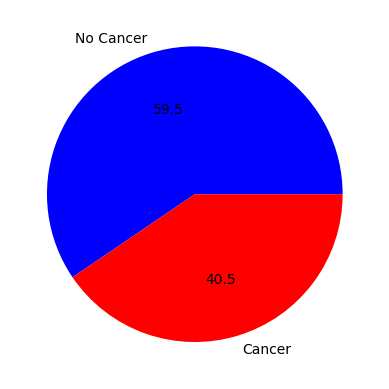

In [5]:
plt.pie(train_df.label.value_counts(), labels=['No Cancer', 'Cancer'], colors=['blue', 'red'], autopct='%1.1f')
plt.show()

In [6]:
# Check for image string

img = TRAIN_DIR + train_df.id[5]
fobj = open(img, "rb")
#fobj.peek(10)

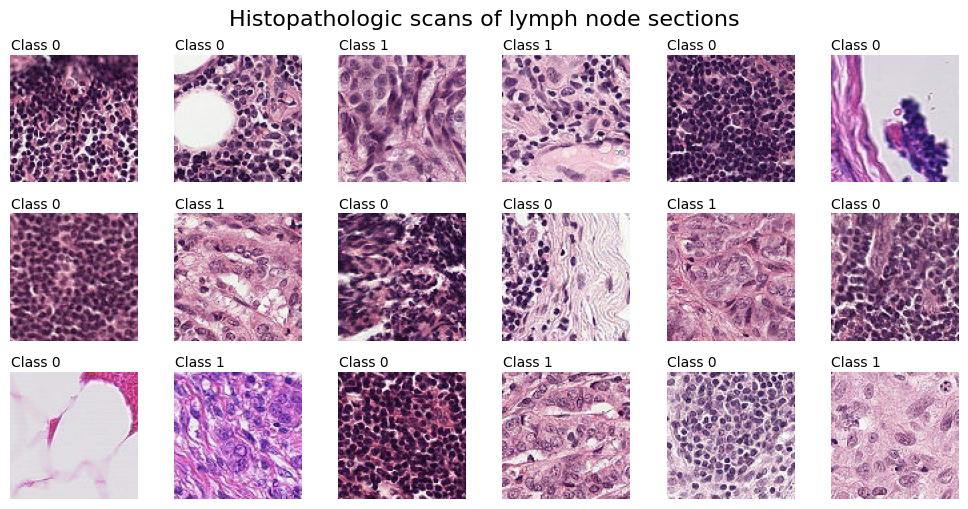

In [7]:
# plot few Train images

sample = train_df.sample(n=18).reset_index()
plt.figure(figsize=(10,10))
plt.suptitle('Histopathologic scans of lymph node sections',fontsize=16)
for i, row in sample.iterrows():
    img = imread(TRAIN_DIR + f'{row.id}')    
    label = row.label

    plt.subplot(6,6,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')        
    plt.axis('off')

plt.tight_layout()
plt.show()

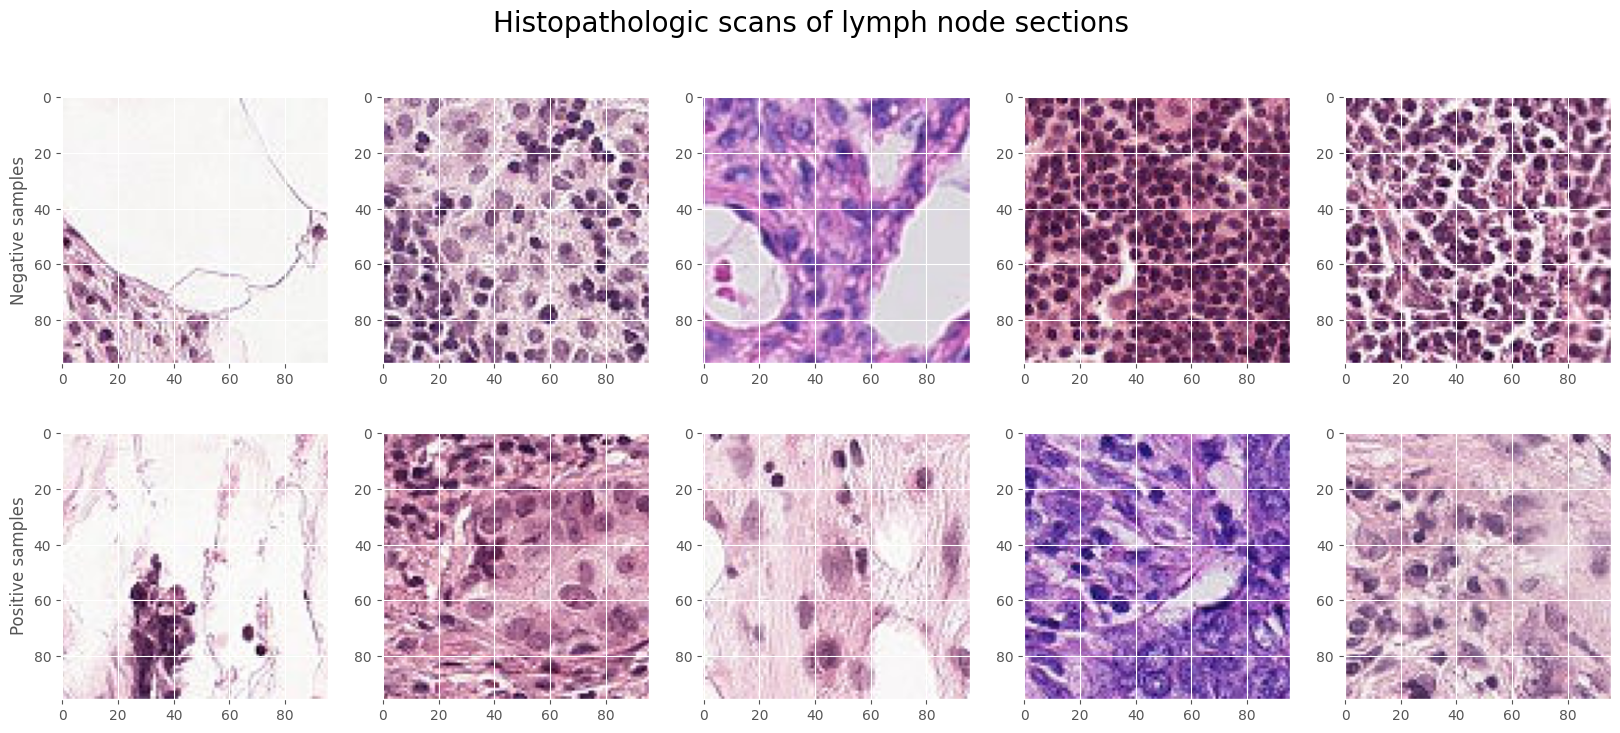

In [8]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)


# Negatives
for i, idx in enumerate(train_df[train_df['label'] == '0']['id'][:5]):
    path = os.path.join(TRAIN_DIR, idx)
    img = imread(path)
    ax[0,i].imshow(img)
ax[0,0].set_ylabel('Negative samples', size='large')


# # Positives
for i, idx in enumerate(train_df[train_df['label'] == '1']['id'][:5]):
    path = os.path.join(TRAIN_DIR, idx)
    img = imread(path)
    ax[1,i].imshow(img)
ax[1,0].set_ylabel('Positive samples', size='large');

In [9]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_df, stratify=train_df['label'], test_size=0.25)
print(len(train), len(val))
print("Train Label Distribution:")
print(train['label'].value_counts())

print("\nValidation Label Distribution:")
print(val['label'].value_counts())


165018 55007
Train Label Distribution:
label
0    98181
1    66837
Name: count, dtype: int64

Validation Label Distribution:
label
0    32727
1    22280
Name: count, dtype: int64


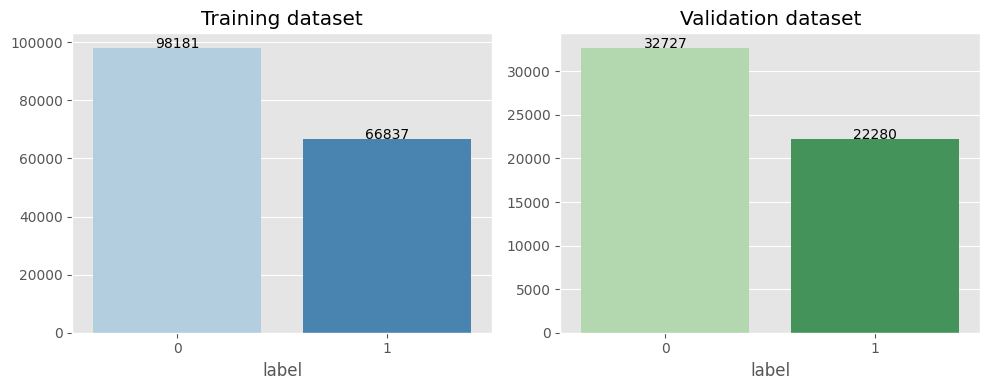

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


# Reset the index of the val DataFrame
val.reset_index(drop=True, inplace=True)
# Reset the index of the train DataFrame
train.reset_index(drop=True, inplace=True)
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot train dataset
sns.barplot(x=train['label'].value_counts().index, y=train['label'].value_counts().values, palette="Blues", ax=ax[0])
ax[0].set_title("Training dataset")
for i, rows in enumerate(train['label'].value_counts().values):
    ax[0].annotate(int(rows), xy=(i, rows), ha='center')

# Plot validation dataset using barplot
sns.barplot(x=val['label'].value_counts().index, y=val['label'].value_counts().values, palette="Greens", ax=ax[1])
ax[1].set_title("Validation dataset")
for i, rows in enumerate(val['label'].value_counts().values):
    ax[1].annotate(int(rows), xy=(i, rows), ha='center')

# Display plots
plt.tight_layout()
plt.show()

In [11]:
# Model Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
import os
import torchvision.transforms as transforms
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score,roc_auc_score
import time
from PIL import Image
from torchvision import transforms
import cv2
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image
import copy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 20
batch_size = 256
num_classes = 2
learning_rate = 0.1
path='../input/histopathologic-cancer-detection/train/'
annotation_file='../input/histopathologic-cancer-detection/train_labels.csv'
test_path='../input/histopathologic-cancer-detection/test/'
train_data =pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
sub = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
train_data.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [12]:
from torch.utils.checkpoint import checkpoint_sequential
class CNN(nn.Module):
    def __init__(self, num_classes=2):  # Assume binary classification, can be changed
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 32, 3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2, 2))
        
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, 3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2, 2))
        
        self.conv3 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2, 2))
        
        self.conv4 = nn.Sequential(
                        nn.Conv2d(128, 256, 3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2, 2))
        
        self.conv5 = nn.Sequential(
                        nn.Conv2d(256, 512, 3, stride=1, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2, 2))
        
        self.fc = nn.Sequential(
                nn.Linear(25088, 256),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(256),
                nn.Dropout(0.4),
                nn.Linear(256, 2)
            )
      
        
    def forward(self, x):
        
        x = self.conv1(x)
        #print("After conv1:", x.shape)  # Debug print
        
        x = self.conv2(x)
        #print("After conv2:", x.shape)  # Debug print
        
        x = self.conv3(x)
        #print("After conv3:", x.shape)  # Debug print
        
        x = self.conv4(x)
        #print("After conv4:", x.shape)  # Debug print
        
        x = self.conv5(x)
        #print("After conv5:", x.shape)  # Debug print
        
        x = x.view(x.size(0), -1)
        #print("After flattening:", x.shape)  # Debug print
        
        x = self.fc(x)
        #print("After fc:", x.shape)  # Debug print
        
        return x

In [13]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), p

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df_data, data_dir, labels=None, transform=None):
        self.data_dir = data_dir
        self.df_data = df_data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name = self.df_data.iloc[index, 0]  # Assuming the first column contains file paths

        # Add the '.tif' extension if not already present
        if not img_name.endswith('.tif'):
            img_name += '.tif'

        img_path = os.path.join(self.data_dir, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            # Skip this image and get the next one
            return self.__getitem__(index + 1)

        if self.transform:
            image = self.transform(image)

        # If labels are provided, return the image and label
        if self.labels is not None:
            label = self.labels[index]
            return image, label

        # If labels are not provided, return only the image
        return image




In [16]:
# Assuming 'label' is a column in your dataframes 'train', 'val', 'sub'
train_labels = train['label'].tolist()
val_labels = val['label'].tolist()

# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = CustomDataset(df_data=train, data_dir=path, labels=train_labels, transform=transform_train)
val_dataset = CustomDataset(df_data=val, data_dir=path, labels=val_labels, transform=transform_val)
test_dataset = CustomDataset(df_data=sub, data_dir=test_path, transform=transform_test)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [17]:
len(test_dataloader)

225

In [18]:

# Reducing batch size
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Initialize lists for metrics
train_losses = []
val_losses = []
train_auc = []
val_auc = []
train_auc_epoch = []
val_auc_epoch = []

best_acc = 0.0
min_loss = np.Inf

since = time.time()

for e in range(num_epochs):
    
    train_loss = 0.0
    val_loss = 0.0
    
    # Train the model
    model.train()
    for i, (images, labels_tuple) in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
        images = images.to(device)
        labels = torch.tensor([int(label) for label in labels_tuple]).to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        y_actual = labels.data.cpu().numpy()
        y_pred = outputs[:,-1].detach().cpu().numpy()
        train_auc.append(roc_auc_score(y_actual, y_pred))
    
    # Evaluate the model
    model.eval()
    for i, (images, labels_tuple) in enumerate(tqdm(val_dataloader, total=len(val_dataloader))):
        images = images.to(device)
        labels = torch.tensor([int(label) for label in labels_tuple]).to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        val_loss += loss.item()
        y_actual = labels.data.cpu().numpy()
        y_pred = outputs[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))
    
    # Average losses and accuracies
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    training_auc = np.mean(train_auc)
    validation_auc = np.mean(val_auc)
    train_auc_epoch.append(training_auc)
    val_auc_epoch.append(validation_auc)
    
    # Updating best validation accuracy
    if best_acc < validation_auc:
        best_acc = validation_auc
        
    # Saving best model
    if min_loss >= val_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        min_loss = val_loss
    
    print(f'EPOCH {e+1}/{num_epochs} Train loss: {train_loss:.6f}, Validation loss: {val_loss:.6f}, Train AUC: {training_auc:.4f}, Validation AUC: {validation_auc:.4f}\n')
    print('-' * 10)

time_elapsed = time.time() - since
print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best validation accuracy: {best_acc:.4f}')


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 1/20 Train loss: 0.431202, Validation loss: 0.470009, Train AUC: 0.9061, Validation AUC: 0.8913

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 2/20 Train loss: 0.362433, Validation loss: 0.350474, Train AUC: 0.9204, Validation AUC: 0.9091

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 3/20 Train loss: 0.314413, Validation loss: 0.633544, Train AUC: 0.9303, Validation AUC: 0.9223

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 4/20 Train loss: 0.266310, Validation loss: 8.992767, Train AUC: 0.9387, Validation AUC: 0.8438

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 5/20 Train loss: 0.251371, Validation loss: 0.535936, Train AUC: 0.9451, Validation AUC: 0.8639

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 6/20 Train loss: 0.256760, Validation loss: 0.315561, Train AUC: 0.9485, Validation AUC: 0.8773

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 7/20 Train loss: 0.229756, Validation loss: 0.311706, Train AUC: 0.9521, Validation AUC: 0.8887

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 8/20 Train loss: 0.193000, Validation loss: 0.614700, Train AUC: 0.9558, Validation AUC: 0.8944

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 9/20 Train loss: 0.198529, Validation loss: 0.218146, Train AUC: 0.9588, Validation AUC: 0.9034

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 10/20 Train loss: 0.176257, Validation loss: 0.253424, Train AUC: 0.9614, Validation AUC: 0.9102

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 11/20 Train loss: 0.193349, Validation loss: 0.221758, Train AUC: 0.9637, Validation AUC: 0.9157

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 12/20 Train loss: 0.151765, Validation loss: 2.070289, Train AUC: 0.9658, Validation AUC: 0.8956

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 13/20 Train loss: 0.165592, Validation loss: 0.298110, Train AUC: 0.9677, Validation AUC: 0.9007

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 14/20 Train loss: 0.130651, Validation loss: 0.432734, Train AUC: 0.9694, Validation AUC: 0.9049

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 15/20 Train loss: 0.132320, Validation loss: 0.624828, Train AUC: 0.9710, Validation AUC: 0.9052

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 16/20 Train loss: 0.158521, Validation loss: 0.244944, Train AUC: 0.9723, Validation AUC: 0.9098

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 17/20 Train loss: 0.114382, Validation loss: 0.258597, Train AUC: 0.9736, Validation AUC: 0.9140

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 18/20 Train loss: 0.103703, Validation loss: 0.232313, Train AUC: 0.9748, Validation AUC: 0.9179

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 19/20 Train loss: 0.110761, Validation loss: 0.241561, Train AUC: 0.9759, Validation AUC: 0.9213

----------


  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH 20/20 Train loss: 0.088188, Validation loss: 0.184505, Train AUC: 0.9770, Validation AUC: 0.9245

----------
Training completed in 124m 28s
Best validation accuracy: 0.9245


In [19]:
# Get a list of all image file paths in your test dataset
image_paths = [os.path.join(test_path, img_name + '.tif') for img_name in sub['id']]

# Check if each file exists
for img_path in image_paths:
    if not os.path.exists(img_path):
        print(f"File {img_path} does not exist.")
    

In [20]:
sub = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
test_dataset = CustomDataset(df_data=sub, data_dir=test_path, transform=transform_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
sub.head()

id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

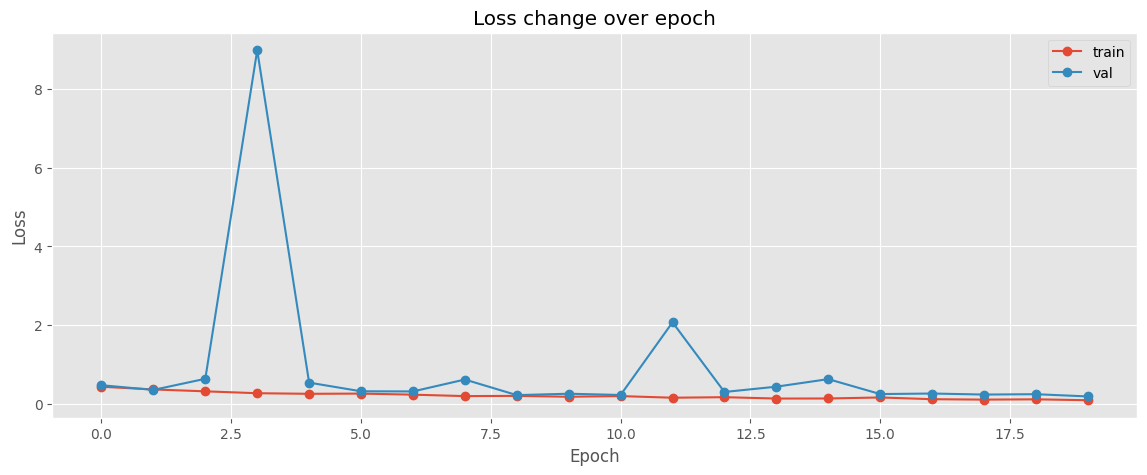

In [21]:
plt.figure(figsize=(14,5))
plt.plot(train_losses, '-o', label="train")
plt.plot(val_losses, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss change over epoch")
plt.legend()

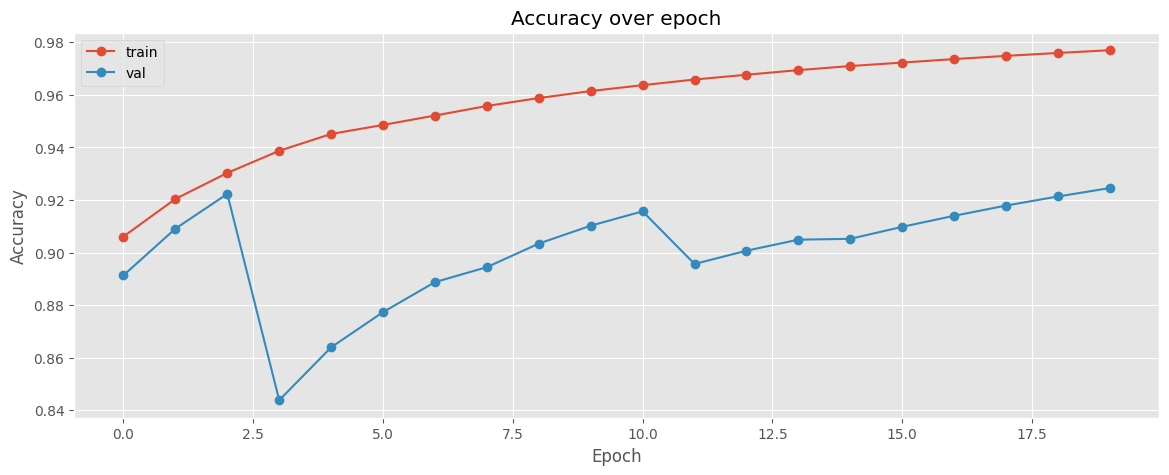

In [22]:
plt.figure(figsize=(14,5))
plt.plot(train_auc_epoch, '-o', label="train")
plt.plot(val_auc_epoch, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()

In [23]:
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [24]:
# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Set the model to evaluation mode
model.eval()

# Initialize a list to store the predictions
predictions = []

for i, images in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
    # Move the images to the device
    images = images.to(device)
    
    # Forward pass
    outputs = model(images)
    
    # Get the predicted class for each image
    _, preds = torch.max(outputs, 1)
    
    # Append the predictions to the list
    predictions.extend(preds.cpu().numpy())


  0%|          | 0/449 [00:00<?, ?it/s]

In [25]:
test_df = pd.DataFrame(sub)
# Convert predictions to float
predictions = [float(pred) for pred in predictions]
submission = test_df.copy()
submission['id']=submission['id']
submission['label']=predictions


In [26]:
# Create a copy of the DataFrame
submission = test_df.copy()

# Assign predictions to the 'label' column
submission['label'] = predictions

# Count occurrences of each label
label_counts = submission['label'].value_counts()

# Display the number of columns with label 1 and label 0
num_label_1 = label_counts.get(1, 0)
num_label_0 = label_counts.get(0, 0)

print("Number of columns with label 1:", num_label_1)
print("Number of columns with label 0:", num_label_0)
# Display the data types of each column
column_types = submission.dtypes
print("Data types of columns in submission DataFrame:\n", column_types)

Number of columns with label 1: 21042
Number of columns with label 0: 36416
Data types of columns in submission DataFrame:
 id        object
label    float64
dtype: object


In [27]:
submission.to_csv('submission.csv', index=False)

print("Submission file saved successfully.")

# Read the CSV file back into a DataFrame with explicitly specified data types
submission_df_read = pd.read_csv('submission.csv', dtype={'id': str})

# Print the data types of columns
column_types = submission_df_read.dtypes
print("Data types of columns in submission.csv file:\n", column_types)



Submission file saved successfully.
Data types of columns in submission.csv file:
 id        object
label    float64
dtype: object


In [28]:
submission.head()

id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5   0.00
1  95596b92e5066c5c52466c90b69ff089b39f2737   0.00
2  248e6738860e2ebcf6258cdc1f32f299e0c76914   0.00
3  2c35657e312966e9294eac6841726ff3a748febf   0.00
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6   0.00

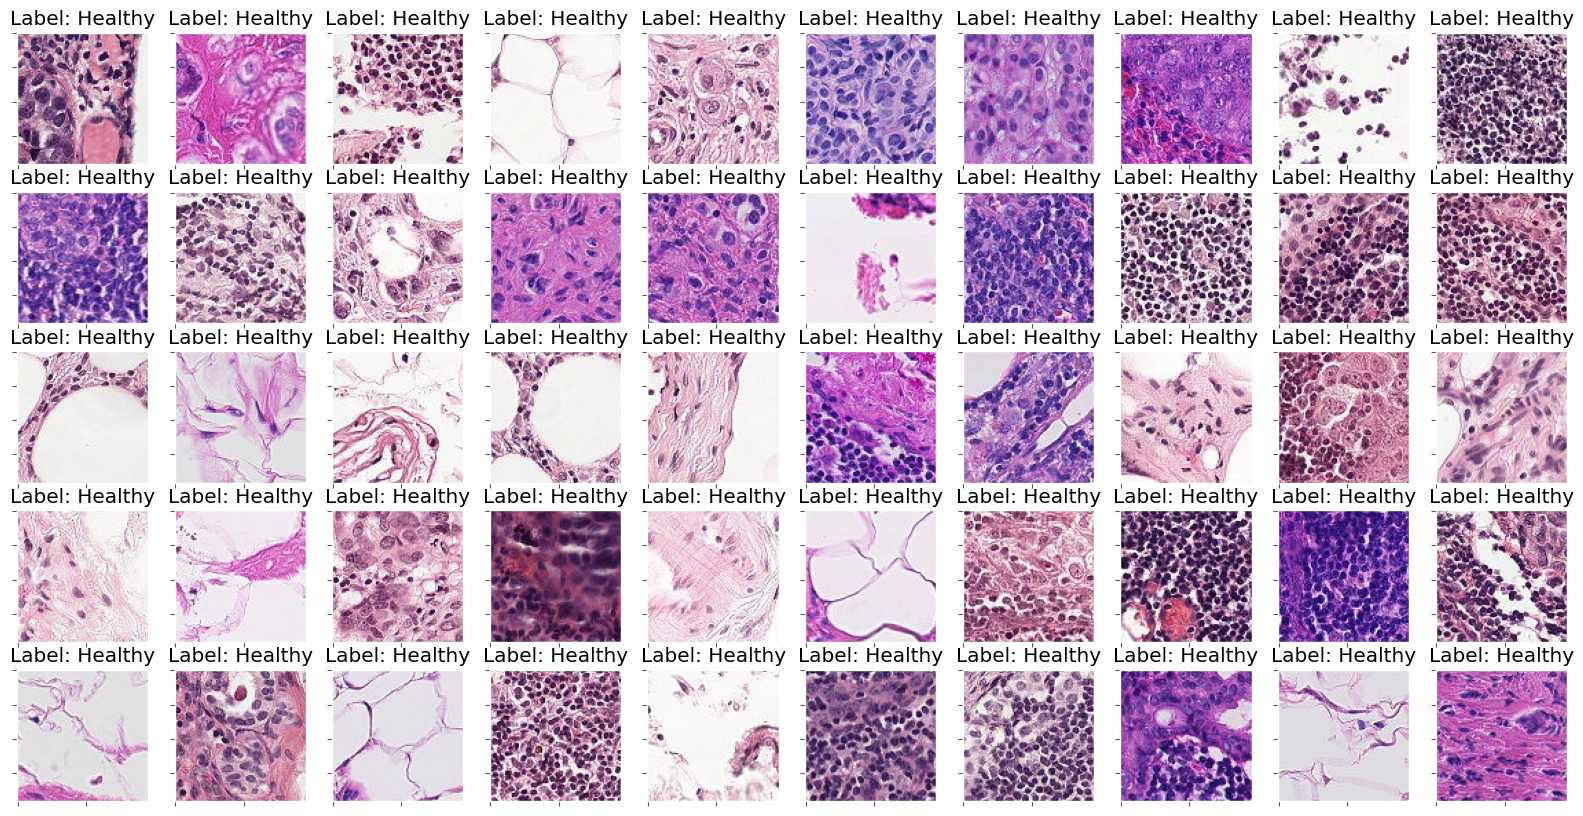

In [29]:
test_images = np.random.choice(sub.id, size=50, replace=False)     

fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = test_images[m + n*10]
        image = plt.imread(test_path + img_id + ".tif")
        pred = sub.loc[sub['id'] == img_id, 'label'].values[0]
        label = "Cancer" if(pred >= 0.5) else "Healthy"  
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)
        ax[n,m].set_title("Label: " + label)